 *Name* : ***Enab***

*Surname*: ***Muneer***

 *Matricola*: ***0001057723*** 

## Blind Source Separation.

Import Dependencies.

In [ ]:
#import section
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate,Reshape
from sklearn.model_selection import train_test_split

## Fetching Data
We load the MNIST and FASHION MNIST data set.

splitting train sets into train and validation sets.
validation split size is 0.33.

In [ ]:
#loading datasets
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()

#splitting train sets into train and validation sets
#validation split size is 0.33
mnist_x_train, mnist_x_val, mnist_y_train, mnist_y_val = train_test_split(
    mnist_x_train, mnist_y_train,
    test_size=0.33, random_state=42)
fashion_mnist_x_train, fashion_mnist_x_val, fashion_mnist_y_train, fashion_mnist_y_val = train_test_split(
    fashion_mnist_x_train, fashion_mnist_y_train,
    test_size=0.33, random_state=42)

#normnalize and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
mnist_x_val = np.pad(mnist_x_val,((0,0),(2,2),(2,2)))/255.

fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_val = np.pad(fashion_mnist_x_val,((0,0),(2,2),(2,2)))/255.

## Data Generator for the model

'''This fucntion returns the concatinated MNIST and The FASHION MNIST images. '''

In [ ]:
np.random.seed(42)

def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_data, y_data

In [ ]:
input_shape = (32,32,1)

# Building the model

The model used is a U-net syle model with 3 upsampling and 3 downsampling levels. I have used only 3 levels because our image is small.

In [ ]:
def build_model(input_layer, start_neurons, levels, n_conv):
    x = input_layer
    
    # Downsampling
    down = []
    for i in range(0, levels):
        for j in range(n_conv):
            x = Conv2D(start_neurons * (2**i), (3, 3), activation="relu", padding="same")(x)
            x = layers.BatchNormalization(momentum = 0.5)(x)
            x = layers.ReLU()(x)
        down.append(x)
        x = MaxPooling2D((2, 2))(x)

    # Middle
    for j in range(n_conv):
        x = Conv2D(start_neurons * (2**i), (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization(momentum = 0.5)(x)
        x = layers.ReLU()(x)
    
    # Upsampling
    for i in range(levels-1, -1, -1):
        deconv = Conv2DTranspose(start_neurons * (2**i), (3, 3), strides=(2, 2), padding="same")(x)
        conv = down.pop()
        x = concatenate([deconv, conv])
        for j in range(n_conv):
            x = Conv2D(start_neurons * (2**i), (3, 3), activation="relu", padding="same")(x)
            x = layers.BatchNormalization(momentum = 0.5)(x)
            x = layers.ReLU()(x)
    
    output_layer = Conv2D(2, (1,1), padding="same", activation="sigmoid")(x)
    
    o1 = output_layer[:, :, :, 0]
    o2 = output_layer[:, :, :, 1]
    output_layer = tf.concat([o1, o2], axis=2)
    
    return output_layer

input_layer = layers.Input(input_shape)
output_layer = build_model(input_layer, start_neurons=128, levels=3, n_conv=2)

modelNew = ks.models.Model(inputs=[input_layer], outputs=[output_layer])


Printing the summary of the model used below.

In [ ]:
modelNew.compile(optimizer=ks.optimizers.Adam(learning_rate=1e-3),
              loss='mse',
              metrics=['mse'])
print(modelNew.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 128)  1280        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_14 (BatchN  (None, 32, 32, 128)  512        ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_14 (ReLU)                (None, 32, 32, 128)  0           ['batch_normalization_14[0]

Plotting the Unet model.

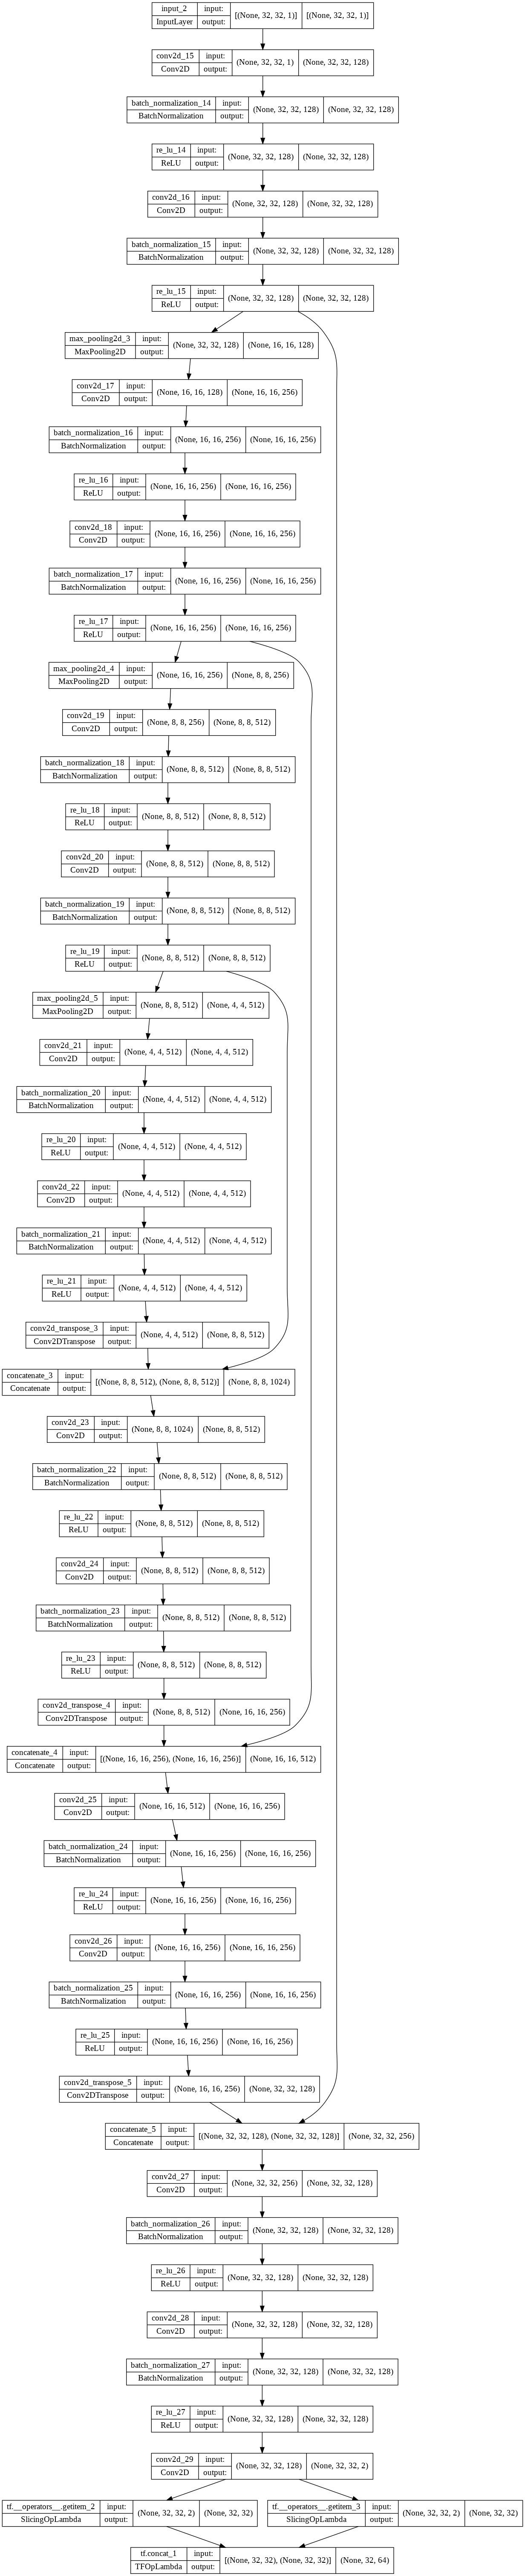

In [ ]:
 ks.utils.plot_model(model=modelNew, to_file='EnabMuneer.png', show_shapes=True)

Defining the three data generators each for training, validation and test set respectively.

In [ ]:
batchSize = 64
train_generator = datagenerator(mnist_x_train,fashion_mnist_x_train, batchSize)
test_generator = datagenerator(mnist_x_test,fashion_mnist_x_test, batchSize)
val_generator = datagenerator(mnist_x_val,fashion_mnist_x_val, batchSize)

## Training the model

The model was trained for 60 epochs, with a batch size of 64 and in each epoch 1000 iterations were used.
Early stopinng was used in order to prevent overfitting.
Also A variable learning rate was used ranging from 0.001 to 0.00001 in order to find a robust local minima.

The metric used is the mean squared error.

In [ ]:
nEpochs = 60
train_steps = 1000
val_steps = 500

reduce_lr = ks.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=5, min_lr=1e-5, verbose=1)
callback = ks.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

history = modelNew.fit(train_generator, steps_per_epoch=train_steps,
          validation_data = val_generator, validation_steps=val_steps,
          batch_size = batchSize, epochs = nEpochs,
          callbacks=[reduce_lr, callback])

Epoch 1/60
1000/1000 [==============================] - 189s 176ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0014 - val_mse: 0.0014 - lr: 0.0010
Epoch 2/60
1000/1000 [==============================] - 180s 180ms/step - loss: 0.0012 - mse: 0.0012 - val_loss: 0.0012 - val_mse: 0.0012 - lr: 0.0010
Epoch 3/60
1000/1000 [==============================] - 182s 182ms/step - loss: 9.9347e-04 - mse: 9.9347e-04 - val_loss: 8.6074e-04 - val_mse: 8.6074e-04 - lr: 0.0010
Epoch 4/60
1000/1000 [==============================] - 182s 182ms/step - loss: 8.8799e-04 - mse: 8.8799e-04 - val_loss: 7.7543e-04 - val_mse: 7.7543e-04 - lr: 0.0010
Epoch 5/60
1000/1000 [==============================] - 182s 182ms/step - loss: 8.2632e-04 - mse: 8.2632e-04 - val_loss: 7.7643e-04 - val_mse: 7.7643e-04 - lr: 0.0010
Epoch 6/60
1000/1000 [==============================] - 181s 181ms/step - loss: 7.4535e-04 - mse: 7.4535e-04 - val_loss: 6.6879e-04 - val_mse: 6.6879e-04 - lr: 0.0010
Epoch 7/60
1000/1000 [========

'modelNew.fit(train_generator, steps_per_epoch=train_steps,\n          validation_data = val_generator, validation_steps=val_steps,\n          batch_size = batchSize, epochs = nEpochs,\n          callbacks=[callback,reduce_lr])'

Calculating Mean Square Error and Standard Deviation for the Test Set.

We observe the the mean MSE achieved is 0.000368 and the standard deviation is 8.945e-07

In [ ]:
mse = np.zeros(10)
for i in range(10):
    mse[i]=modelNew.evaluate(test_generator, steps=2000)[0]
mean_mse=mse.mean()
std=mse.std()
print('mean = ', mean_mse, '\nstd = ', std)

2000/2000 [==============================] - 114s 57ms/step - loss: 3.6760e-04 - mse: 3.6760e-04
mean =  0.0003681087662698701 
std =  8.945341562509293e-07


Testing the model by looking at the input, predicted and the original pair of Images.

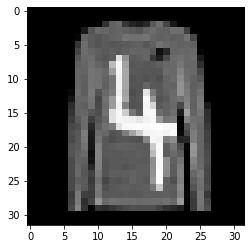

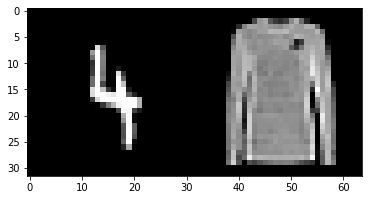

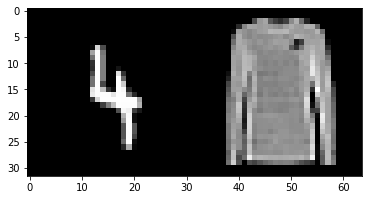

In [ ]:
test_generator2 = datagenerator(mnist_x_test,fashion_mnist_x_test, 1)
test_x, test_y = next(test_generator2)
test_x = np.transpose(test_x, (1,2,0))
test_x = np.array([test_x])

predicted = modelNew.predict(test_x)

plt.imshow(test_x[0, :,:,0],cmap='gray', interpolation='nearest')
plt.show()

plt.imshow(predicted[0,:,:],cmap='gray', interpolation='nearest')
plt.show()

test_y = np.transpose(test_y, (1,2,0))
plt.imshow(test_y[:,:,0], cmap='gray', interpolation='nearest')
plt.show()

modelNew.save("EnabMuneer.h5")
modelNew.save_weights("EnabMuneer_weigths.h5")

Thank you.